In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from findiff import Diff
import math
from tqdm import tqdm


In [2]:
# make sure you are in the ddmp-flax repo 
import os
#show the current working directory
os.getcwd()
#change the current working directory to 'd:\\diffusion model\\TEST3\\denoising-diffusion-flax-20250107T081638Z-001\\denoising-diffusion-flax\\denoising_diffusion_flax'
os.chdir('d:\\diffusion model\\TEST4\\denoising-diffusion-flax-20250107T081638Z-001\\denoising-diffusion-flax-v5-LC\\get_training_data\\v2')
#show the current working directory
os.getcwd()

'd:\\diffusion model\\TEST4\\denoising-diffusion-flax-20250107T081638Z-001\\denoising-diffusion-flax-v5-LC\\get_training_data\\v2'

In [3]:
def generate_mask(N1,N2,icx,icy,R,anchoring_type,inclusion,*args):
    x,y = np.meshgrid(np.arange(N1), np.arange(N2))
    mask = np.zeros((N1,N2,2))
    # find the normal vector of the boundary
    r = np.sqrt((x-icx)**2 + (y-icy)**2) 
    r[r==0] = 1e-4
    vx = (x-icx)/r
    vy = (y-icy)/r
    azi = np.arctan2(vy,vx)
    if inclusion:
        mask[:,:,1][ r < R] = 1 # 1 means discard
    else:
        mask[:,:,1][ r > R] = 1
    assert not np.any(np.isnan(azi)), 'azi has nan values'
    if anchoring_type==1: #homeotropic
        mask[:,:,0] = azi
    elif anchoring_type==2: #planar
        mask[:,:,0] = 0.5*np.pi+azi
    elif anchoring_type==3: #arbitrary
        mask[:,:,0] = args[0]*np.pi+azi
    elif anchoring_type==4: # +1/2
        mask[:,:,0] = 0.5*azi+args[0]*np.pi
    elif anchoring_type==5:
        mask[:,:,0] = -0.5*azi+args[0]*np.pi
    return mask

In [4]:
def generate_mask_triangle(Ax,Ay,Bx,By,Cx,Cy,N1,N2,inclusion,anchoring_type,*args):
    x,y = np.meshgrid(np.arange(N1), np.arange(N2))
    mask = np.zeros((N1,N2,2))
    #vector AB
    ABx = Bx - Ax
    ABy = By - Ay
    #vector BC
    BCx = Cx - Bx
    BCy = Cy - By
    #vector CA
    CAx = Ax - Cx
    CAy = Ay - Cy
    #vector PA
    PAx = x - Ax
    PAy = y - Ay
    #vector PB
    PBx = x - Bx
    PBy = y - By
    #vector PC
    PCx = x - Cx
    PCy = y - Cy
    #cross product AB and AP
    cross_AB_AP = ABx*PAy - ABy*PAx
    #cross product BC and BP
    cross_BC_BP = BCx*PBy - BCy*PBx
    #cross product CA and CP
    cross_CA_CP = CAx*PCy - CAy*PCx
    #check if the point is inside the triangle
    # if the point is inside the triangle, the cross product should have same sign for all three edges
    # generate a boolean of size (N1,N2) for cross_AB_AP > 0 & cross_BC_BP > 0 & cross_CA_CP > 0


    mask[:,:,1][(cross_AB_AP > 0) & (cross_BC_BP>0) & (cross_CA_CP>0)] = 1 
    mask[:,:,1][(cross_AB_AP < 0) & (cross_BC_BP<0) & (cross_CA_CP<0)] = 1 
    mask[:,:,1][(cross_AB_AP == 0) & (cross_BC_BP>0) & (cross_CA_CP>0)] = 1 
    mask[:,:,1][(cross_AB_AP == 0) & (cross_BC_BP<0) & (cross_CA_CP<0)] = 1 
    mask[:,:,1][(cross_BC_BP == 0) & (cross_CA_CP>0) & (cross_AB_AP>0)] = 1 
    mask[:,:,1][(cross_BC_BP == 0) & (cross_CA_CP<0) & (cross_AB_AP<0)] = 1
    mask[:,:,1][(cross_CA_CP == 0) & (cross_AB_AP>0) & (cross_BC_BP>0)] = 1
    mask[:,:,1][(cross_CA_CP == 0) & (cross_AB_AP<0) & (cross_BC_BP<0)] = 1
    if inclusion:
        mask[:,:,1] = 1-mask[:,:,1]
    # find the distance from P to the line AB
    # cross product of AB and AP = |AB|*|AP|*sin(theta)
    # distance = |cross product|/|AB|
    length_AB = np.sqrt(ABx**2 + ABy**2)
    length_BC = np.sqrt(BCx**2 + BCy**2)
    length_CA = np.sqrt(CAx**2 + CAy**2)
    #distance from P to AB
    d_AB = np.abs(cross_AB_AP)/length_AB
    #distance from P to BC
    d_BC = np.abs(cross_BC_BP)/length_BC
    #distance from P to CA
    d_CA = np.abs(cross_CA_CP)/length_CA
    # pick the minimum distance to set the anchoring
    d = np.stack([d_AB,d_BC,d_CA],axis=-1)
    index = np.argmin(d,axis=-1)
    print(index)
    # set the anchoring based on the index
    anchoring = np.zeros((N1,N2,3))
    # anchoring 0: along AB, find the angle of the normal vector of AB
    # find the normal vector of AB
    n_ABx = -ABy/length_AB
    n_ABy = ABx/length_AB
    Azi_n_AB = np.arctan2(n_ABy,n_ABx)
    # find the angle of the normal vector of BC
    n_BCx = -BCy/length_BC
    n_BCy = BCx/length_BC
    Azi_n_BC = np.arctan2(n_BCy,n_BCx)
    # find the angle of the normal vector of CA
    n_CAx = -CAy/length_CA
    n_CAy = CAx/length_CA
    Azi_n_CA = np.arctan2(n_CAy,n_CAx)
    # find the centroid of the triangle
    cx = (Ax + Bx + Cx)/3
    cy = (Ay + By + Cy)/3
    vx = x - cx
    vy = y - cy
    Azi = np.arctan2(vy,vx)
    if anchoring_type==1:
        # homeotropic anchoring
        mask[:,:,0][index==0] = Azi_n_AB
        mask[:,:,0][index==1] = Azi_n_BC
        mask[:,:,0][index==2] = Azi_n_CA
    elif anchoring_type==2:
        # planar anchoring
        mask[:,:,0][index==0] = 0.5*np.pi + Azi_n_AB
        mask[:,:,0][index==1] = 0.5*np.pi + Azi_n_BC
        mask[:,:,0][index==2] = 0.5*np.pi + Azi_n_CA
    elif anchoring_type==3:
        # arbitrary anchoring
        mask[:,:,0] = Azi 
    elif anchoring_type==4:
        mask[:,:,0] = Azi + 0.5*np.pi



    return mask, index

In [ ]:
def generate_mask_pentagon(Ax,Ay,Bx,By,Cx,Cy,Dx,Dy,Ex,Ey,N1,N2,inclusion,anchoring_type,*args):
    x,y = np.meshgrid(np.arange(N1), np.arange(N2))
    mask = np.zeros((N1,N2,2))
    #vector AB
    ABx = Bx - Ax
    ABy = By - Ay
    #vector BC
    BCx = Cx - Bx
    BCy = Cy - By
    #vector CD
    CDx = Dx - Cx
    CDy = Dy - Cy
    #vector DE
    DEx = Ex - Dx
    DEy = Ey - Dy
    #vector EA
    EAx = Ax - Ex
    EAy = Ay - Ey
    #vector PA
    PAx = x - Ax
    PAy = y - Ay
    #vector PB
    PBx = x - Bx
    PBy = y - By
    #vector PC
    PCx = x - Cx
    PCy = y - Cy
    #vector PD
    PDx = x - Dx
    PDy = y - Dy
    #vector PE
    PEx = x - Ex
    PEy = y - Ey
    #cross product AB and AP
    cross_AB_AP = ABx*PAy - ABy*PAx
    #cross product BC and BP
    cross_BC_BP = BCx*PBy - BCy*PBx
    #cross product CD and CP
    cross_CD_CP = CDx*PCy - CDy*PCx
    #cross product DE and DP
    cross_DE_DP = DEx*PDy - DEy*PDx
    #cross product EA and EP
    cross_EA_EP = EAx*PEy - EAy*PEx
    #check if the point is inside the triangle
    # if the point is inside the triangle, the cross product should have same sign for all three edges
    # generate a boolean of size (N1,N2) for cross_AB_AP > 0 & cross_BC_BP > 0 & cross_CA_CP > 0


    mask[:,:,1][(cross_AB_AP > 0) & (cross_BC_BP>0) & (cross_CD_CP>0) & (cross_DE_DP>0) & (cross_EA_EP>0)] = 1
    mask[:,:,1][(cross_AB_AP < 0) & (cross_BC_BP<0) & (cross_CD_CP<0) & (cross_DE_DP<0) & (cross_EA_EP<0)] = 1
    mask[:,:,1][(cross_AB_AP == 0) & (cross_BC_BP>0) & (cross_CD_CP>0) & (cross_DE_DP>0) & (cross_EA_EP>0)] = 1
    mask[:,:,1][(cross_AB_AP == 0) & (cross_BC_BP<0) & (cross_CD_CP<0) & (cross_DE_DP<0) & (cross_EA_EP<0)] = 1
    mask[:,:,1][(cross_BC_BP == 0) & (cross_CD_CP>0) & (cross_DE_DP>0) & (cross_EA_EP>0) & (cross_AB_AP>0)] = 1
    mask[:,:,1][(cross_BC_BP == 0) & (cross_CD_CP<0) & (cross_DE_DP<0) & (cross_EA_EP<0) & (cross_AB_AP<0)] = 1
    mask[:,:,1][(cross_CD_CP == 0) & (cross_DE_DP>0) & (cross_EA_EP>0) & (cross_AB_AP>0) & (cross_BC_BP>0)] = 1
    mask[:,:,1][(cross_CD_CP == 0) & (cross_DE_DP<0) & (cross_EA_EP<0) & (cross_AB_AP<0) & (cross_BC_BP<0)] = 1
    mask[:,:,1][(cross_DE_DP == 0) & (cross_EA_EP>0) & (cross_AB_AP>0) & (cross_BC_BP>0) & (cross_CD_CP>0)] = 1
    mask[:,:,1][(cross_DE_DP == 0) & (cross_EA_EP<0) & (cross_AB_AP<0) & (cross_BC_BP<0) & (cross_CD_CP<0)] = 1
    mask[:,:,1][(cross_EA_EP == 0) & (cross_AB_AP>0) & (cross_BC_BP>0) & (cross_CD_CP>0) & (cross_DE_DP>0)] = 1
    mask[:,:,1][(cross_EA_EP == 0) & (cross_AB_AP<0) & (cross_BC_BP<0) & (cross_CD_CP<0) & (cross_DE_DP<0)] = 1

    if inclusion:
        mask[:,:,1] = 1-mask[:,:,1]
    # find the distance from P to the line AB
    # cross product of AB and AP = |AB|*|AP|*sin(theta)
    # distance = |cross product|/|AB|
    length_AB = np.sqrt(ABx**2 + ABy**2)
    length_BC = np.sqrt(BCx**2 + BCy**2)
    length_CD = np.sqrt(CDx**2 + CDy**2)
    length_DE = np.sqrt(DEx**2 + DEy**2)
    length_EA = np.sqrt(EAx**2 + EAy**2)
    #distance from P to AB
    d_AB = np.abs(cross_AB_AP)/length_AB
    #distance from P to BC
    d_BC = np.abs(cross_BC_BP)/length_BC
    #distance from P to CD
    d_CD = np.abs(cross_CD_CP)/length_CD
    #distance from P to DE
    d_DE = np.abs(cross_DE_DP)/length_DE
    #distance from P to EA
    d_EA = np.abs(cross_EA_EP)/length_EA
    # pick the minimum distance to set the anchoring
    d = np.stack([d_AB,d_BC,d_CD,d_DE,d_EA],axis=-1)
    index = np.argmin(d,axis=-1)
    # anchoring 0: along AB, find the angle of the normal vector of AB
    # find the normal vector of AB
    n_ABx = -ABy/length_AB
    n_ABy = ABx/length_AB
    Azi_n_AB = np.arctan2(n_ABy,n_ABx)
    # find the angle of the normal vector of BC
    n_BCx = -BCy/length_BC
    n_BCy = BCx/length_BC
    Azi_n_BC = np.arctan2(n_BCy,n_BCx)
    # find the angle of the normal vector of CD
    n_CDx = -CDy/length_CD
    n_CDy = CDx/length_CD
    Azi_n_CD = np.arctan2(n_CDy,n_CDx)
    # find the angle of the normal vector of DE
    n_DEx = -DEy/length_DE
    n_DEy = DEx/length_DE
    Azi_n_DE = np.arctan2(n_DEy,n_DEx)
    # find the angle of the normal vector of EA
    n_EAx = -EAy/length_EA
    n_EAy = EAx/length_EA
    Azi_n_EA = np.arctan2(n_EAy,n_EAx)
    # find the centroid of the triangle
    cx = (Ax + Bx + Cx + Dx + Ex)/5
    cy = (Ay + By + Cy + Dy + Ey)/5
    vx = x - cx
    vy = y - cy
    Azi = np.arctan2(vy,vx)
    if anchoring_type==1:
        # homeotropic anchoring
        mask[:,:,0][index==0] = Azi_n_AB
        mask[:,:,0][index==1] = Azi_n_BC
        mask[:,:,0][index==2] = Azi_n_CD
        mask[:,:,0][index==3] = Azi_n_DE
        mask[:,:,0][index==4] = Azi_n_EA
    elif anchoring_type==2:
        # planar anchoring
        mask[:,:,0][index==0] = 0.5*np.pi + Azi_n_AB
        mask[:,:,0][index==1] = 0.5*np.pi + Azi_n_BC
        mask[:,:,0][index==2] = 0.5*np.pi + Azi_n_CD
        mask[:,:,0][index==3] = 0.5*np.pi + Azi_n_DE
        mask[:,:,0][index==4] = 0.5*np.pi + Azi_n_EA
    elif anchoring_type==3:
        # arbitrary anchoring
        mask[:,:,0] = Azi 
    elif anchoring_type==4:
        mask[:,:,0] = Azi + 0.5*np.pi



    return mask, index

In [6]:
def relaxationBC_inclusion(N1, N2, Azi, t_max, mask,    
    ywallbottom_angle=np.pi,
    ywalltop_angle=np.pi,
    xwallleft_angle=np.pi,
    xwallright_angle=np.pi,     
    ywalltop_anchoring=0,
    ywallbottom_anchoring=0,
    xwallleft_anchoring=0,
    xwallright_anchoring=0,
    ):
    # output_fig = 200
    # t_max = 2000
    gamma = 2
    Seq = np.sqrt(2)/gamma
    sigma = 0.1
    

    

    Qxx = Seq * np.cos(Azi*2)
    Qxy = Seq * np.sin(Azi*2)


    # generate index to differentiate between the interior and the boundary
    interior = np.ones((N2, N1))
    interior[0, :] = 0
    interior[-1, :] = 0
    interior[:, 0] = 0
    interior[:, -1] = 0
    boundary = np.zeros((N2,N1))
    boundary[0, :] = 1
    boundary[-1, :] = 1
    boundary[:, 0] = 1
    boundary[:, -1] = 1

    # generate normal vector for the boundary
    vx = np.zeros((N2, N1))
    vy = np.zeros((N2, N1))

    # y = 0 not include x=0 and x=L1 v=[0,-1]  ywallbottom
    vy[0, 1:-1] = -1 
    # y = L2 v=[0,1] ywalltop
    vy[-1, 1:-1] = 1
    # x = 0 v=[-1,0] xwallleft
    vx[:, 0] = -1
    # x = L1 v=[1,0] xwallright
    vx[:, -1] = 1


    # defined prefer Q_0
    Azi_prefer = np.zeros((N2,N1))
    Azi_prefer[0,:]=ywallbottom_angle
    Azi_prefer[-1,:]=ywalltop_angle
    Azi_prefer[:,0]=xwallleft_angle
    Azi_prefer[:,-1]=xwallright_angle

    Qxx_0 = Seq * np.cos(Azi_prefer*2) * boundary
    Qxy_0 = Seq * np.sin(Azi_prefer*2) * boundary


    #anchoring strength of different wall
    W = boundary
    W[:,0]=xwallleft_anchoring
    W[:,-1]=xwallright_anchoring
    W[0,:]=ywallbottom_anchoring
    W[-1,:]=ywalltop_anchoring

    f=np.zeros(t_max)
    for t in tqdm(range(t_max)):
        

        # calculate Q gradient
        d_dx = Diff(1, 1,acc=2)
        d_dy = Diff(0, 1,acc=2)
        laplacian = d_dx**2+d_dy**2
        dxdQxx = d_dx(Qxx)
        dydQxx = d_dy(Qxx)
        dxdQxy = d_dx(Qxy)
        dydQxy = d_dy(Qxy)
        del2Qxx = laplacian(Qxx)
        del2Qxy = laplacian(Qxy)
        # calculate free energy
        f1 = (-0.5 / gamma)* (Qxx**2 + Qxy**2) + 0.25 * (Qxx**2 + Qxy**2)**2 + 0.5 * (dxdQxx**2 + dydQxx**2 + dxdQxy**2 + dydQxy**2)
        f1[mask[:,:,1]!=0] = 0
        f[t] = np.sum(f1, axis=(0,1))
        assert not np.isnan(dxdQxx).any()
        assert not np.isnan(dxdQxy).any()
        thermoQxx = (1/gamma**2) * Qxx - 2 * (Qxx**2 + Qxy**2) * Qxx
        thermoQxy = (1/gamma**2) * Qxy - 2 * (Qxx**2 + Qxy**2) * Qxy
        dQxxdt_bulk = del2Qxx + thermoQxx
        dQxydt_bulk = del2Qxy + thermoQxy
        # evolve interior Q
        dQxxdt_bulk *= interior
        dQxydt_bulk *= interior
        # evolve boundary Q
        dQxxdt_surf = (dxdQxx * vx + dydQxx * vy) + W*(Qxx*boundary-Qxx_0*boundary)
        dQxydt_surf = (dxdQxy * vx + dydQxy * vy) + W*(Qxy*boundary-Qxy_0*boundary)

        dQxxdt = dQxxdt_bulk - dQxxdt_surf
        dQxydt = dQxydt_bulk - dQxydt_surf
        assert not np.isnan(dQxxdt).any()
        assert not np.isnan(dQxydt).any()
        dQxxdt[mask[:,:,1]!=0] = 0
        dQxydt[mask[:,:,1]!=0] = 0
        Qxx = Qxx + dQxxdt * sigma
        Qxy = Qxy + dQxydt * sigma



    Q = np.stack((Qxx, Qxy), axis=-1)
    return Q, f

In [7]:
Qxxtotal = []
Qxytotal = []

Generate Mask

(64, 64, 2)
(64, 64)


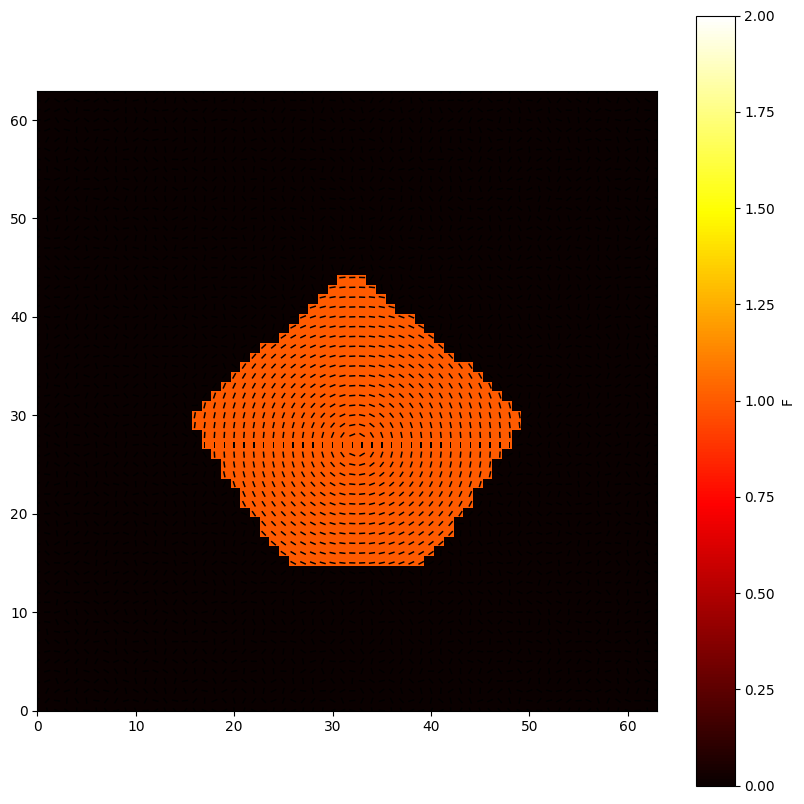

In [13]:


# Initial condition
# Initial mesh grid
N1 = 64
L1 = 64
N2 = 64
L2 = 64

dx = L1 / N1
dy = L2 / N2

x, y = np.meshgrid(np.arange(0, L1, dx), np.arange(0, L2, dy))
Azi = np.random.rand(N2, N1) * 2 * np.pi  # Random initial condition for Azi
# mask = generate_mask(N1, N2, 20, 20, 10.5, 3, False, -1.2)
# mask = generate_mask(N1, N2, 20, 20, 10.5, 1, False, -1.2)
# mask, index = generate_mask_triangle(15, 15, 45, 45, 20, 45, N1, N2, False, 4)
mask, index = generate_mask_pentagon(25, 15, 40, 15, 50, 30, 32, 45, 15, 30, N1, N2, False, 4)
print(mask.shape)
# # let Azi be the value of mask non-zero value
Azi[mask[:,:,1]!=0] = mask[:,:,0][mask[:,:,1]!=0]
print(Azi.shape)
nx = np.cos(Azi)
ny = np.sin(Azi)
plt.figure(figsize=(10, 10))
plt.imshow(mask[:,:,1], cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=2)
plt.colorbar(label='F')  # Add a colorbar to show the scale
# plt.title(' Heatmap of F')
# plt.xlabel('x')
# plt.ylabel('y')
plt.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
# plt.quiver(x[mask[:,:,1]==0], y[mask[:,:,1]==0], nx[mask[:,:,1]==0], ny[mask[:,:,1]==0], color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
plt.show() 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
kernel = torch.tensor([[[[0, 1, 0], [1, 0, 1], [0, 1, 0]]]], dtype=torch.float32)
result = F.conv2d(torch.tensor(1-mask[:,:,1], dtype=torch.float32).unsqueeze(0).unsqueeze(0), kernel, padding=1)
result = result[0,0].detach().numpy()
result[result<1.] = np.nan
result[result>3.] = np.nan
plt.figure(figsize=(10, 10))
plt.imshow(result*(1-mask[:,:,1]), cmap='turbo', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=28)
plt.colorbar()  # Add a colorbar to show the scale
nx[mask[:,:,1]==1]=0
ny[mask[:,:,1]==1]=0
plt.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
# plt.quiver(x[mask[:,:,1]==0], y[mask[:,:,1]==0], nx[mask[:,:,1]==0], ny[mask[:,:,1]==0], color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
plt.show() 
# a=result[0, 0].detach().numpy()
# a *= 1-mask[:,:,1]
# plt.figure(figsize=(10, 10))
# plt.imshow(a, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=4)
#  # Add a discrete colorbar to show the scale
# plt.colorbar(ticks=[0, 1, 2, 3, 4])

In [ ]:

Layer,f = relaxationBC_inclusion(N1, N2, Azi, 5000, mask,    ywalltop_anchoring=1,
    ywallbottom_anchoring=1, xwallleft_anchoring=1,
    xwallright_anchoring=1)
# Qxxtotal.append(Layer[:,:,0].flatten())
# Qxytotal.append(Layer[:,:,1].flatten())

# print(np.array(Qxxtotal).shape)
Qxx = Layer[:,:,0]
Qxy = Layer[:,:,1]
nx = np.zeros((N2,N1))
ny = np.zeros((N2,N1))
S = np.zeros((N2,N1))

for i in range(N2):
    for j in range(N1):
        matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                        [Qxy[i, j], -Qxx[i, j]]])
        vals, vecs = np.linalg.eigh(matrix)
        index = np.argmax(vals)
        nx[i,j] = vecs[0, index]
        ny[i,j] = vecs[1, index]
        S[i,j] = vals[index]*2
S[mask[:,:,1]!=0] = np.nan
nx[mask[:,:,1]!=0] = np.nan
ny[mask[:,:,1]!=0] = np.nan
plt.figure(figsize=(10, 10))
plt.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=1)
plt.colorbar(label='F')  # Add a colorbar to show the scale
plt.title(' Heatmap of F')
plt.xlabel('x')
plt.ylabel('y')
plt.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
# plt.quiver(x[mask[:,:,1]==0], y[mask[:,:,1]==0], nx[mask[:,:,1]==0], ny[mask[:,:,1]==0], color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
plt.show() 

plt.figure()
plt.plot(f[2:])



In [ ]:
Qxxtotal = np.array(Qxxtotal)
Qxytotal = np.array(Qxytotal)
Qxxtotal1 = Qxxtotal[:2160,:]
Qxytotal1 = Qxytotal[:3500,:]
print(Qxxtotal1.shape)
# convert back to list
Qxxtotal1 = Qxxtotal1.tolist()
Qxytotal1 = Qxytotal1.tolist()
Qxxtotal = Qxxtotal.tolist()
Qxytotal = Qxytotal.tolist()
print(np.array(Qxxtotal1).shape)